# AntEpiSeeker analysis on Commercial dataset

## Generating .012 input file

### Preprocessing genotype file

As described in [Notebook](./AntEpiSeeker_Ala.ipynb) for Alanine dataset analysis, `AntEpiSeeker` needs genotype in "012" format and binary phenotype:

- firstly, we removed indels from `.vcf` file using `VCFtools` v0.1.16:

In [1]:
! vcftools --vcf ../../data/commercial_genotypes.vcf --remove-indels --recode --recode-INFO-all --out ../../data/commercial_genotypes_snps
! mv ../../data/commercial_genotypes_snps.recode.vcf ../../data/commercial_genotypes_snps.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../../data/commercial_genotypes.vcf
	--recode-INFO-all
	--out ../../data/commercial_genotypes_snps
	--recode
	--remove-indels

After filtering, kept 97 out of 97 Individuals
Outputting VCF file...
After filtering, kept 29336 out of a possible 31676 Sites
Run Time = 1.00 seconds


- secondly, imputing missed genotypes using `BEAGLE` v5.4

We noticed that some contigs have zero length and Beagle can't perform well with them being present. Let's drop them and try once again. For that purpose we'll use `pdbio` Python3 library (Cock, P.J.A. et al. Biopython: freely available Python tools for computational molecular biology and bioinformatics. Bioinformatics 2009 Jun 1; 25(11) 1422-3 https://doi.org/10.1093/bioinformatics/btp163 pmid:19304878) that provides a simple way to read `.vcf` files to Pandas table.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from pdbio.vcfdataframe import VcfDataFrame
import re

from parsing_ant import (parse_features, parse_string,
                     parse_snp_coord, generate_bed_file_unique,
                     assign_gene_for_snp, parse_gene_info)

import warnings
warnings.filterwarnings('ignore')
# parse_kegg_results

In [2]:
data = VcfDataFrame(path="../../data/commercial_genotypes_snps.vcf")

In [3]:
data.df

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,b2_l001_s1.bam,...,b3_l147_s1.bam,b4_l148_s2.bam,b4_l151_s1.bam,b3_l152_s1.bam,b4_l153_s1.bam,b4_l154_s2.bam,b3_l155_s1.bam,b4_l156_s1.bam,b4_l157_s2.bam,b4_l159_s1.bam
0,1,40522,.,C,T,999,.,.,GT:PL,"0/0:0,12,75",...,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.
1,1,41592,.,T,A,4100.94,.,.,GT:PL,"0/0:0,96,255",...,"0/1:125,0,77","0/1:255,0,255","0/0:0,33,255","0/1:166,0,74","0/1:255,0,255","0/0:0,12,153","./.:0,0,0","0/1:255,0,255","0/1:255,0,255","0/1:255,0,255"
2,1,111641,.,G,C,999,.,.,GT:PL,"0/1:64,0,31",...,"./.:0,0,0","0/1:156,0,88","./.:0,0,0","1/1:67,6,0","1/1:109,15,0","./.:0,0,0","1/1:67,6,0","1/1:154,21,0","1/1:67,6,0","1/1:67,6,0"
3,1,111675,.,G,C,999,.,.,GT:PL,"0/1:64,0,51",...,"./.:0,0,0","0/1:255,0,212","./.:0,0,0","1/1:70,6,0","1/1:174,15,0","./.:0,0,0","1/1:73,6,0","1/1:198,21,0","1/1:80,6,0","1/1:73,6,0"
4,1,111688,.,T,C,999,.,.,GT:PL,"0/1:64,0,30",...,"./.:0,0,0","0/1:156,0,82","./.:0,0,0","1/1:67,6,0","1/1:129,15,0","./.:0,0,0","1/1:67,6,0","1/1:154,21,0","1/1:67,6,0","1/1:67,6,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29331,KZ848124,2376,.,A,G,999,.,.,GT:PL,"1/1:0,118,8",...,"0/1:25,0,16","1/1:73,255,0","1/1:6,81,0","1/1:82,164,0","1/1:1,13,0","0/1:0,0,25","1/1:97,93,0","1/1:46,104,0","0/1:13,0,30","1/1:20,60,0"
29332,KZ848124,2400,.,G,A,999,.,.,GT:PL,"0/1:9,0,57",...,"1/1:12,3,0","0/1:35,0,56","0/1:6,0,16","0/1:12,0,99","0/1:26,0,111","0/0:0,3,7","0/1:3,1,0","0/1:2,0,33","0/0:0,3,6","0/1:13,0,21"
29333,KZ848124,2416,.,T,A,999,.,.,GT:PL,"0/1:12,0,54",...,"0/1:4,1,0",./.:.,./.:.,"0/1:15,0,91",./.:.,./.:.,"0/1:3,1,0",./.:.,./.:.,./.:.
29334,KZ848124,2425,.,T,A,999,.,.,GT:PL,"0/1:9,0,57",...,"1/1:20,8,0","0/1:35,0,46","0/1:6,0,16","0/1:13,0,94","0/1:8,0,139","0/0:0,3,7","1/1:15,6,0","0/1:14,0,24","0/0:0,3,6","0/1:13,0,21"


In [17]:
# checking abundance of chromosomes and scaffolds and keeping those presented for then once
check_amount = data.df["#CHROM"].value_counts() > 1

# chromosomes and scaffolds to keep for analysis
retained_chrom = (check_amount).index[check_amount]

In [18]:
print(f"""{data.df.shape[0] - data.df[data.df["#CHROM"].isin(retained_chrom)].shape[0]} records were dropped""")

34 records were dropped


In [19]:
# saving filtered .vcf file
data.df[data.df["#CHROM"].isin(retained_chrom)].to_csv("../../data/commercial_genotypes_snps_filt.vcf", sep="\t", index=False)

Running `BEAGLE` v5.4 for imputation with default parameters:

```
$ java -Xmx50g -jar beagle.22Jul22.46e.jar gt=../SNP_Plastilin/data/commercial_genotypes_snps_filt.vcf \
out=../SNP_Plastilin/data/commercial_genotypes_snps_filled
```

Generated output in `.vcf.gz` format.

- thirdly, converting `.vcf` file to `.012` genotype data using flag `--gzvcf` for input in compressed `.vcf` format and `--012` for conerting genotype into `.012` format:

In [21]:
! vcftools --gzvcf ../../data/commercial_genotypes_snps_filled.vcf.gz --012 --out ../secret_med_input/commercial_genotypes_snps_filled


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ../../data/commercial_genotypes_snps_filled.vcf.gz
	--012
	--out ../secret_med_input/commercial_genotypes_snps_filled

Using zlib version: 1.2.11
After filtering, kept 97 out of 97 Individuals
Writing 012 matrix files ... 	012: Only outputting biallelic loci.
Done.
After filtering, kept 29302 out of a possible 29302 Sites
Run Time = 0.00 seconds


### Generating input file for AntEpiSeeker

- creating SNP names using their location (chrN:pos) from `.012.pos` file (for more description see [README.md](../README.md):

In [2]:
# reading file with SNP coordinates to generate SNP IDs
secret_snp_ids = pd.read_csv("../secret_med_input/commercial_genotypes_snps_filled.012.pos", delimiter="\t", 
                            names=["chr", "pos"])

# to rename chromosome names as chrN, scaffold names keep unchanged
secret_snp_ids['chr'] = secret_snp_ids['chr'].apply(lambda x: 'chr'+x if x in [str(i) for i in range(21)][1:] else x)

# to combine str in chr and pos columns
secret_snp_ids['SNP_ID'] = secret_snp_ids[['chr', 'pos']].astype(str).agg(':'.join, axis=1)
secret_snp_ids.head()

,chr,pos,SNP_ID
0,chr1,40522,chr1:40522
1,chr1,41592,chr1:41592
2,chr1,111641,chr1:111641
3,chr1,111675,chr1:111675
4,chr1,111688,chr1:111688


In [3]:
print(f"{secret_snp_ids.shape[0]} genome variants is in our analysis") 

29230 genome variants is in our analysis


In [4]:
# checking the presence of duplicated variants
dup_check = secret_snp_ids[secret_snp_ids['SNP_ID'].duplicated(keep=False)]
dup_check

,chr,pos,SNP_ID


Each genome variant is presented once.

- combining names with genotype:

In [5]:
# SNP_IDs for column names in 012 matrix from snp_ids
secret_col_names = list(secret_snp_ids['SNP_ID'])

# reading 012 genotype file generated by VCFtools
secret_genotype = pd.read_csv("../secret_med_input/commercial_genotypes_snps_filled.012", sep='\t', 
                              names=secret_col_names, index_col=0)
secret_genotype.head()

,chr1:40522,chr1:41592,chr1:111641,chr1:111675,chr1:111688,chr1:111696,chr1:111712,chr1:111727,chr1:111744,chr1:111752,...,KZ848124:2251,KZ848124:2329,KZ848124:2336,KZ848124:2342,KZ848124:2354,KZ848124:2376,KZ848124:2400,KZ848124:2416,KZ848124:2425,KZ848124:2648
0,0,0,1,1,1,1,1,1,1,1,...,2,0,0,0,2,2,1,1,1,2
1,0,0,1,1,1,1,1,1,1,1,...,1,1,0,0,2,2,2,2,1,1
2,1,1,2,2,2,2,2,2,2,2,...,1,0,0,0,1,0,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,2,1,1,1,0
4,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,1,1


### Combining genotype data with its phenotype

In [6]:
# reading file with commercial phenotype
secret_phenotype = pd.read_csv("../../data/commercial_phenotypes.tsv", sep="\t")
secret_phenotype.head()

,IID,pheno
0,b2_l001_s1.bam,1635.03
1,b1_l003_s1.bam,1561.38
2,b1_l004_s1.bam,1576.11
3,b1_l005_s1.bam,1325.70
4,b1_l007_s1.bam,1325.70


We decided to visualize distribution of phenotype in commercial dataset.

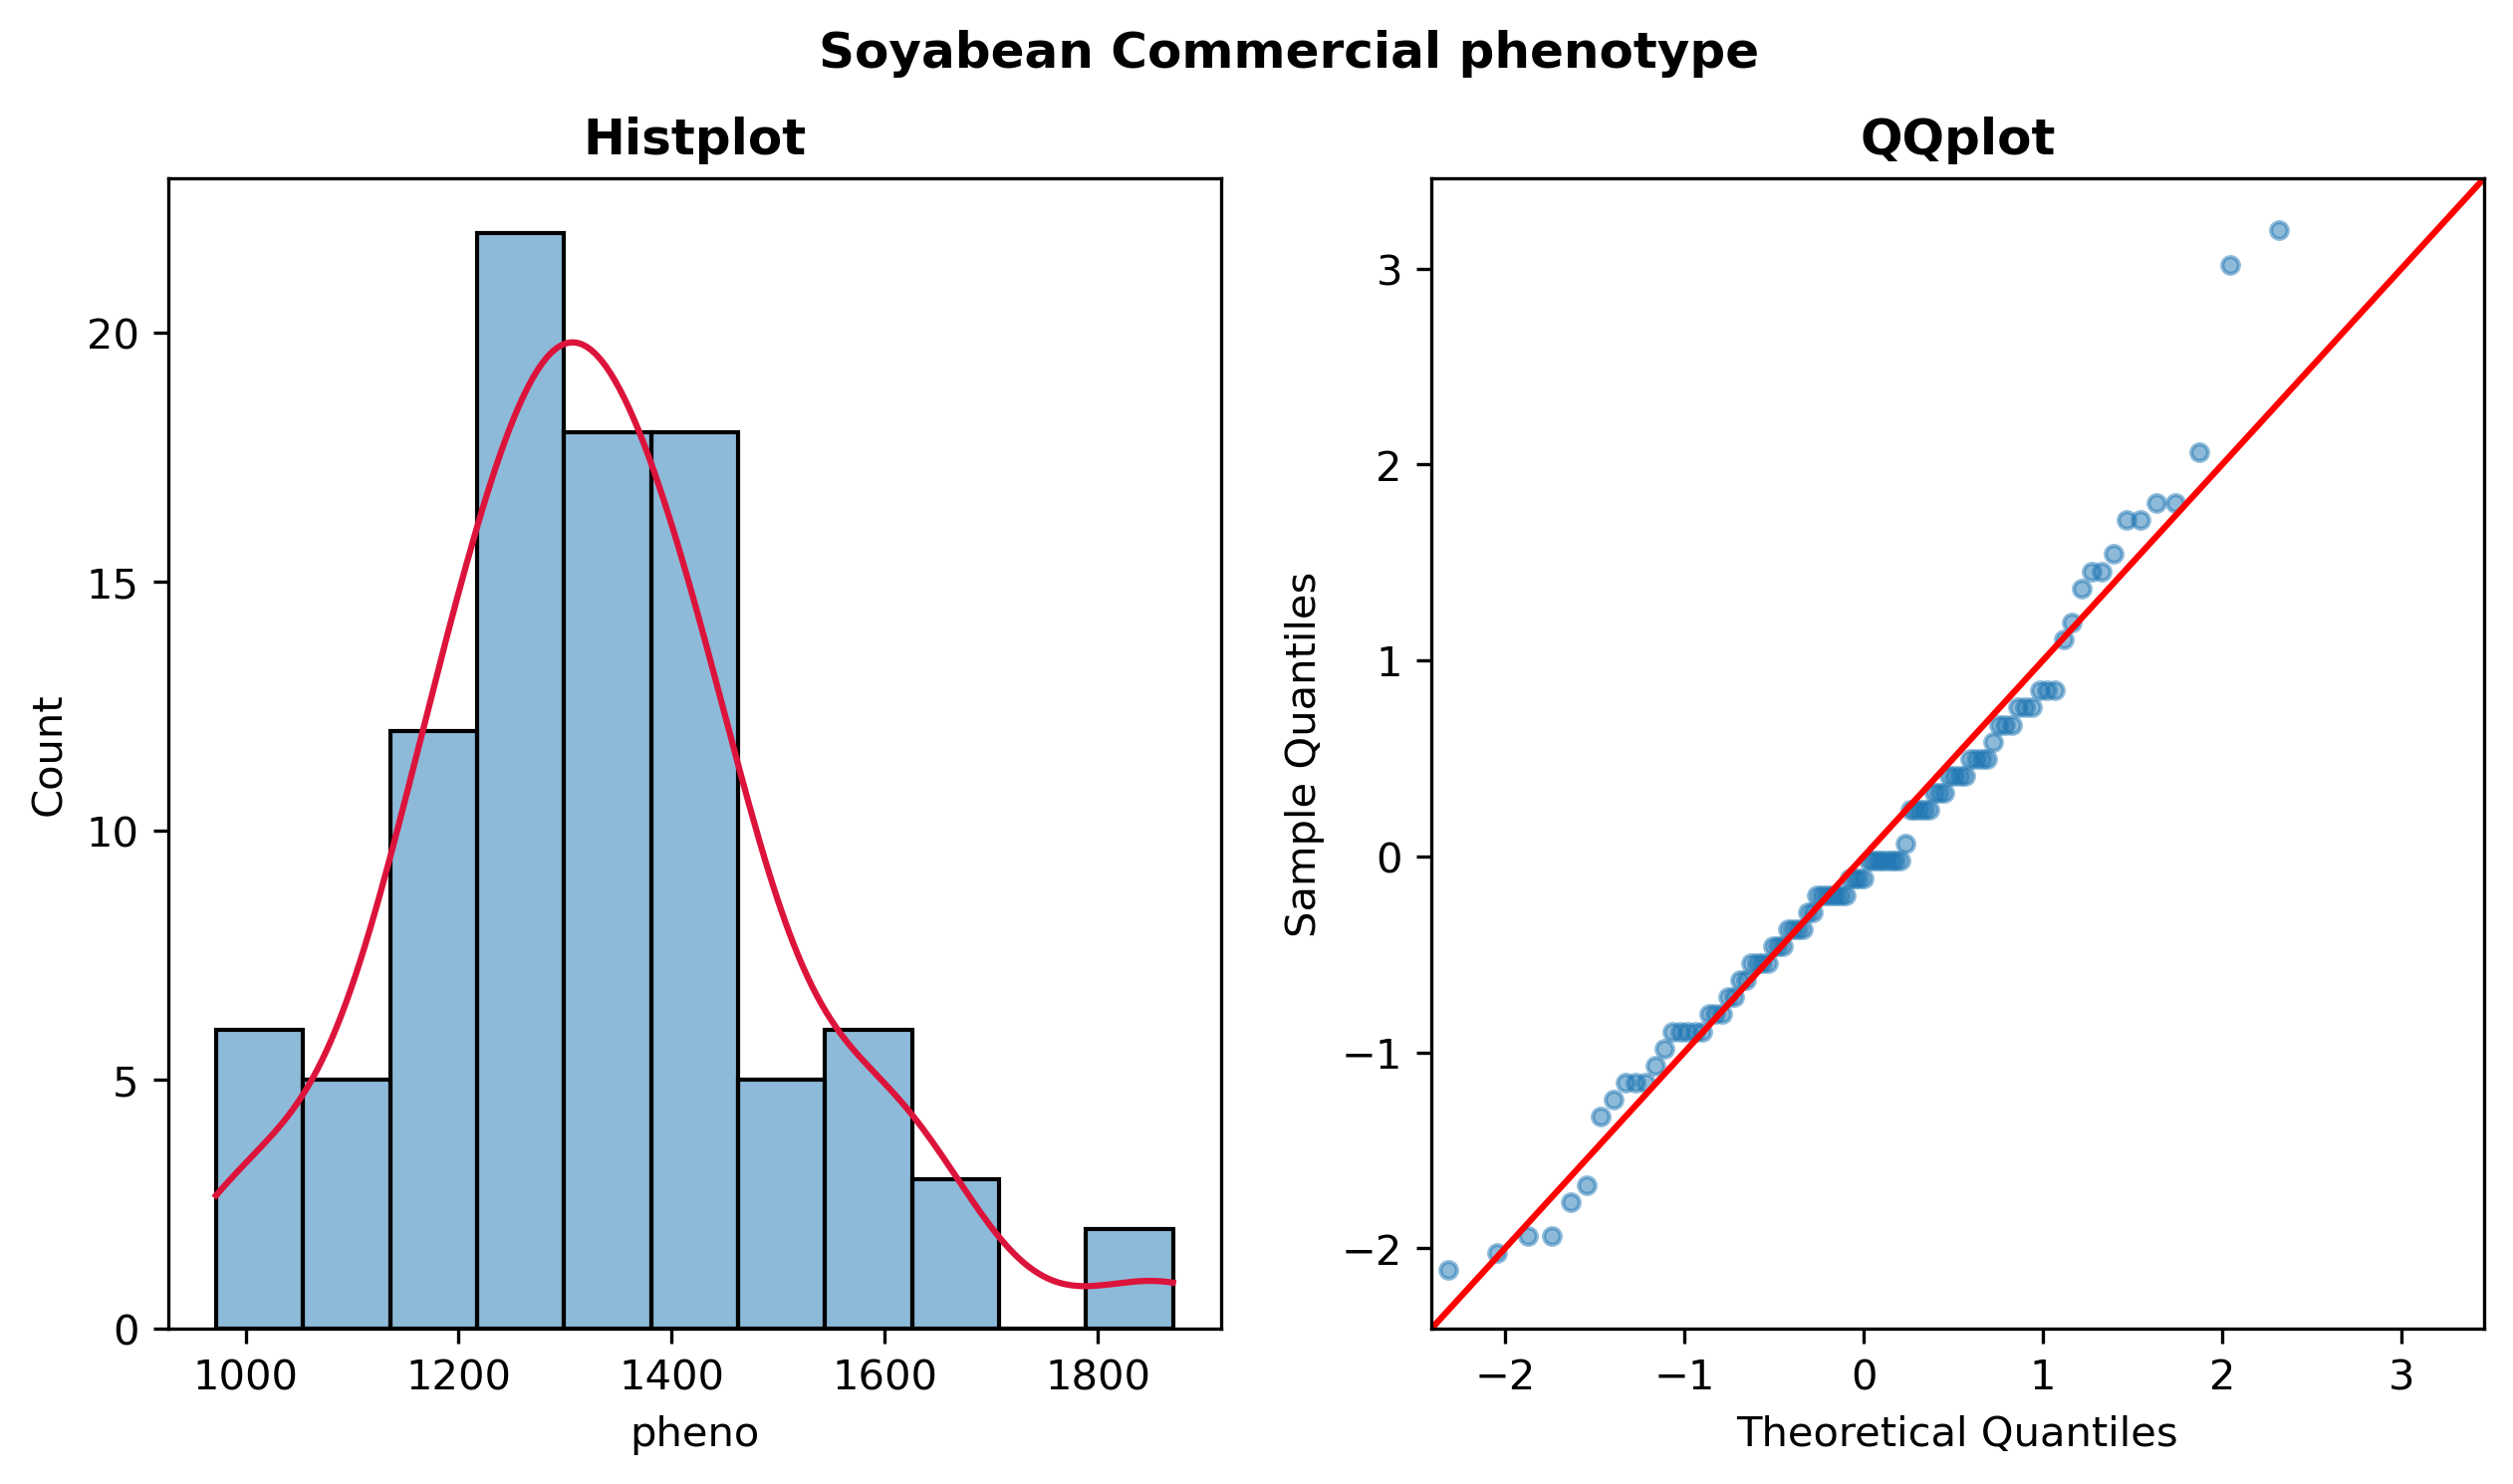

In [7]:
## histplot and qqplot for commercial phenotype
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5), dpi=300)

sns.histplot(secret_phenotype["pheno"], kde=True, ax=axes[0])
axes[0].lines[0].set_color('crimson')
axes[0].set_title("Histplot", fontsize=12, fontweight='bold')
sm.qqplot(secret_phenotype["pheno"], fit=True,
          line='45', ax=axes[1], alpha=0.5, markersize=4)
axes[1].set_title("QQplot", fontsize=12, fontweight='bold')
fig.suptitle("Soyabean Commercial phenotype", fontsize=12, fontweight='bold')
plt.show()

In [8]:
stats.shapiro(secret_phenotype["pheno"])

ShapiroResult(statistic=0.9735694527626038, pvalue=0.047266729176044464)

Secret phenotype distribution is not normal.

Unfortunately, only *qualitative phenotypes* could be analyzed with `AntEpiSeeker`. To tackle this obstacle, we converted *quantitative alanine content phenotype* into *binary* via calculating **the median value of amino acid content** and assigning *“0”* for samples with the value *less than median* and *“1” in the opposite case*.

- Firstly, we combined genotype with with **continuous** commercial phenotype:

In [9]:
# combining genotype with continuous phenotype data
secret_cont = pd.concat([secret_genotype, secret_phenotype["pheno"]], axis=1)

# renaming phenotype column into "class", this is a requirement for `AntEpiSeeker` input file
secret_cont.rename(columns={"pheno": "class"}, inplace=True)
secret_cont.head()

,chr1:40522,chr1:41592,chr1:111641,chr1:111675,chr1:111688,chr1:111696,chr1:111712,chr1:111727,chr1:111744,chr1:111752,...,KZ848124:2329,KZ848124:2336,KZ848124:2342,KZ848124:2354,KZ848124:2376,KZ848124:2400,KZ848124:2416,KZ848124:2425,KZ848124:2648,class
0,0,0,1,1,1,1,1,1,1,1,...,0,0,0,2,2,1,1,1,2,1635.03
1,0,0,1,1,1,1,1,1,1,1,...,1,0,0,2,2,2,2,1,1,1561.38
2,1,1,2,2,2,2,2,2,2,2,...,0,0,0,1,0,1,1,1,1,1576.11
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,2,1,1,1,0,1325.70
4,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,1,1,1325.70


- Secondly, we generated dataset with **discrete** (*med commercial quantitative trait value*) commercial phenotype (0: < median, 1: > median):

In [10]:
# median of commercial trait value
secret_med = secret_cont["class"].median()
print(f"Median commercial quantitative value in samples: {secret_med}")

Median commercial quantitative value in samples: 1310.97


In [11]:
# copying dataframe with commercial quantitative phenotype
secret012_discr_med = secret_cont.copy()

# generating dataset with discrete commercial phenotype
secret012_discr_med["class"] = secret_cont["class"].apply(
    lambda x: 0 if x <= secret_med else 1)

# generating AntEpiSeeker input file
secret012_discr_med.to_csv("../secret_med_input/secret012_discr_med.csv", index=False)
secret012_discr_med.head()

,chr1:40522,chr1:41592,chr1:111641,chr1:111675,chr1:111688,chr1:111696,chr1:111712,chr1:111727,chr1:111744,chr1:111752,...,KZ848124:2329,KZ848124:2336,KZ848124:2342,KZ848124:2354,KZ848124:2376,KZ848124:2400,KZ848124:2416,KZ848124:2425,KZ848124:2648,class
0,0,0,1,1,1,1,1,1,1,1,...,0,0,0,2,2,1,1,1,2,1
1,0,0,1,1,1,1,1,1,1,1,...,1,0,0,2,2,2,2,1,1,1
2,1,1,2,2,2,2,2,2,2,2,...,0,0,0,1,0,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,2,1,1,1,0,1
4,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,1,1,1


Also we checked abundance of each class (0 or 1) in generated input file.

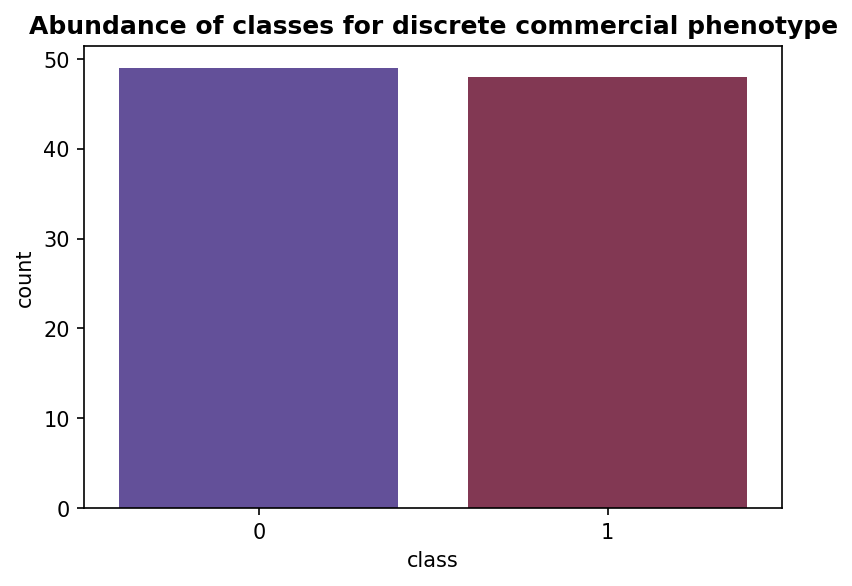

In [12]:
# countplot for an adundance of the classes
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
sns.countplot(x=secret012_discr_med["class"], palette="twilight");
ax.set_title("Abundance of classes for discrete commercial phenotype", fontweight="bold");

## Running **AntEpiSeeker**

### Two loci interaction mode

To run `AntEpiSeeker`, we should specify `parameters.txt` file.

**NOTE**: For description of parameters see [README.md](../README.md) section **AntEpiSeeker parameters**.

| Parameter | Value | Description |
|-----------|:-----:|-------------|
| iAntCount | 1000  | number of ants |
| iItCountLarge | 14616 | number of iterations for the large haplotypes |
| iItCountSmall | 29231  | number of iterations for the small haplotypes |
| alpha     | 1 | weight given to pheromone deposited by ants |
| iTopModel | 1000 | number of top ranking haplotypes in the first stage |
| iTopLoci  | 200 | number of loci with top ranking pheromone in the first stage |
| rou | 0.05 | evaporation rate in Ant Colony Optimizaion |
| phe | 100 | initial pheromone level for each locus |
| largehapsize | 6 | size of the large haplotypes | 
| smallhapsize | 3 | size of the small haplotypes |
| iEpiModel | 2 | number of SNPs in an epistatic interaction |
| pvalue | 0.01 | p value threshold (after Bonferroni correction) |
| INPFILE | ../secret_med_input/secret012_discr_med.csv | input file name for case-control genotype data |
| OUTFILE | ../secret_two_loci/ant_result_secret_med_two_loci.txt | output file name for detected epistatic interactions |

To run this program:

1) go to folder with this tool; 
2) prepare `parameters.txt` file;
3) run command  
`./AntEpiSeeker`

Let's take a look on `AntEpiSeeker` output file.

In [13]:
# reading file with results for alanine datasets and two-loci interaction mode
secret_med_result = pd.read_csv(
    "../secret_two_loci/ant_result_secret_med_two_loci.txt",
    sep='\t', skiprows=2, names=["Loci", "Chi-square", "p-value"]
)

# sorting dataframe by "Chi-square"
secret_med_result.sort_values("Chi-square", ascending=False, ignore_index=True, inplace=True)

# splitting SNP pairs into two columns for convenience
secret_med_result[["SNP1", "SNP2"]] = secret_med_result.Loci.str.split(expand = True)
secret_med_result.head()

,Loci,Chi-square,p-value,SNP1,SNP2
0,13180(chr10:7811292) 4097(chr4:1408537),37.5537,0.000009,13180(chr10:7811292),4097(chr4:1408537)
1,7445(chr6:9128442) 15523(chr12:6176422),36.4949,0.000014,7445(chr6:9128442),15523(chr12:6176422)
2,15521(chr12:6175126) 18569(chr14:35936320),36.4397,0.000015,15521(chr12:6175126),18569(chr14:35936320)
3,415(chr1:26637529) 20386(chr15:41233340),36.0411,0.000017,415(chr1:26637529),20386(chr15:41233340)
4,28121(chr20:35099655) 1239(chr2:2423857),36.0083,0.000017,28121(chr20:35099655),1239(chr2:2423857)


As the result, we obtained **198** interacting SNP pairs.

#### Annotation

#### Preparation of .bed file for intersection with genome annotation

Then we prepared dataframe with SNP coordinates with chromosome names as in genome annotation file.

In [14]:
# generating dataframe with coordinates for each SNP in pairs
secret_med_result = parse_snp_coord(dataframe=secret_med_result, n_snps=2)
secret_med_result.head()

,Loci,Chi-square,p-value,SNP1,SNP2,SNP1_chr,SNP1_pos,SNP2_chr,SNP2_pos
0,13180(chr10:7811292) 4097(chr4:1408537),37.5537,0.000009,chr10:7811292,chr4:1408537,10,7811292,4,1408537
1,7445(chr6:9128442) 15523(chr12:6176422),36.4949,0.000014,chr6:9128442,chr12:6176422,6,9128442,12,6176422
2,15521(chr12:6175126) 18569(chr14:35936320),36.4397,0.000015,chr12:6175126,chr14:35936320,12,6175126,14,35936320
3,415(chr1:26637529) 20386(chr15:41233340),36.0411,0.000017,chr1:26637529,chr15:41233340,1,26637529,15,41233340
4,28121(chr20:35099655) 1239(chr2:2423857),36.0083,0.000017,chr20:35099655,chr2:2423857,20,35099655,2,2423857


In [15]:
# we decided to write SNP pairs (with IDs for each SNPs) in file to keep it as the result of AntEpiSeeker in more readable format
secret_med_result.to_csv("../secret_two_loci/secret_two_loci_SNP_pairs.csv", columns=["SNP1", "SNP2"], index=False)

For further SNP annotation, we combined SNPs, found unique ones among them (in this case, it does not matter to us whether the SNP has met more than once in pairs), so for mapping SNPs on genes and analyze gene-gene interactions.

In [16]:
# path for .bed file
bed_path = "../secret_two_loci/ant_secret_coords/secret_ant_unique_snps"

# generating .bed file for SNP annotation
unique_snps_df = generate_bed_file_unique(dataframe=secret_med_result, bed_path=bed_path)

In [17]:
# this dataframe was written in .bed file
unique_snps_df.head()

,SNP_ID,chr,pos_stop,pos_start
0,chr10:7811292,10,7811292,7811291
1,chr6:9128442,6,9128442,9128441
2,chr12:6175126,12,6175126,6175125
3,chr1:26637529,1,26637529,26637528
4,chr20:35099655,20,35099655,35099654


#### Running bedtools intersect

We need to annotate SNP pairs resulted from `AntEpiSeeker` tool. For this purpose, we intersected SNPs with [genome annotation](https://plants.ensembl.org/Glycine_max/Info/Index) in `.gff3` format, we run `bedtools intersect` as follows:

```
bedtools intersect -wao -a ../secret_two_loci/ant_secret_coords/secret_ant_unique_snps.bed \
-b ../../annotations/Glycine_max.Glycine_max_v2.1.56.gff3.gz > ../secret_two_loci/ant_secret_coords/secret_unique_intersect.txt
```

#### Parsing features and filtering genes

After intersection with annotation file, we parsed resulted features and filtered genes.

In [18]:
# reading intersection file
# we only interested in columns with "SNP_ID", "chr", "type", "start", "stop", "features", "intersection_length"
secret_unique_inter = pd.read_csv("../secret_two_loci/ant_secret_coords/secret_unique_intersect.txt", sep="\t",
                                  usecols=[3, 4, 6, 7, 8, 12], header=None,
                                  names=["SNP_ID", "chr", "type", "start", "stop", "features"])

# filtering features with type "gene"
secret_unique_inter_genes = secret_unique_inter[secret_unique_inter["type"] == "gene"].reset_index(drop=True)

In [19]:
secret_unique_inter_genes.head()

,SNP_ID,chr,type,start,stop,features
0,chr10:7811292,10,gene,7798996,7816511,ID=gene:GLYMA_10G075300;biotype=protein_coding...
1,chr6:9128442,6,gene,9126878,9129754,ID=gene:GLYMA_06G112500;biotype=protein_coding...
2,chr12:6175126,12,gene,6174613,6176858,ID=gene:GLYMA_12G078900;biotype=protein_coding...
3,chr12:6176386,12,gene,6174613,6176858,ID=gene:GLYMA_12G078900;biotype=protein_coding...
4,chr18:53408732,18,gene,53408554,53412303,ID=gene:GLYMA_18G246600;biotype=protein_coding...


The "features" column contains a lot of information. The most valuable for our analysis is "gene ID". We parsed "features" in the following way.

In [20]:
# parsing column "features" to obtain gene attibutes (especially gene IDs)
secret_unique_features = parse_features(secret_unique_inter_genes["features"])

# combining genes with respective SNPs
secret_unique_features = pd.concat([secret_unique_inter_genes["SNP_ID"], secret_unique_features], axis=1)
secret_unique_features.head()

Minor feature: Name


,SNP_ID,ID,biotype,description,gene_id,logic_name
0,chr10:7811292,gene:GLYMA_10G075300,protein_coding,hypothetical protein,GLYMA_10G075300,ena
1,chr6:9128442,gene:GLYMA_06G112500,protein_coding,hypothetical protein,GLYMA_06G112500,ena
2,chr12:6175126,gene:GLYMA_12G078900,protein_coding,hypothetical protein,GLYMA_12G078900,ena
3,chr12:6176386,gene:GLYMA_12G078900,protein_coding,hypothetical protein,GLYMA_12G078900,ena
4,chr18:53408732,gene:GLYMA_18G246600,protein_coding,hypothetical protein,GLYMA_18G246600,ena


It is known that the genome annotation may contain more than one entry about a genomic region (for example, some genes may overlap, or a gene may be annotated by different algorithms). Therefore, we checked whether there are duplicates in our case.

In [21]:
# checking duplicated SNP_IDs
secret_unique_features[secret_unique_features.duplicated(subset="SNP_ID", keep=False)]

,SNP_ID,ID,biotype,description,gene_id,logic_name
147,chr19:33900659,gene:GLYMA_19G096000,protein_coding,hypothetical protein,GLYMA_19G096000,ena
148,chr19:33900659,gene:GLYMA_19G095900,protein_coding,hypothetical protein,GLYMA_19G095900,ena
170,chr10:862296,gene:GLYMA_10G008700,protein_coding,hypothetical protein,GLYMA_10G008700,ena
171,chr10:862296,gene:GLYMA_10G008800,protein_coding,hypothetical protein,GLYMA_10G008800,ena


Yes, *two SNP IDs* were duplicated. All genes are proteing coding and hypothetical. We searched any information in [NCBI](https://www.ncbi.nlm.nih.gov/gene/) and [SoyBase](https://www.soybase.org/) databases about these genes. We did not found any descriptions about the possible functions of *GLYMA_19G096000* and *GLYMA_10G008800* (indices 147 and 171 in dataframe, respectively) and decided to remove them from further analysis. 

In [22]:
# removing genes GLYMA_19G096000 and GLYMA_10G008800 from further analysis
secret_unique_features.drop(index=[147, 171], inplace=True)

In [23]:
# it was interesting to check the presence of verified genes
# only one gene has approved biological function
secret_unique_features[secret_unique_features["description"] != "hypothetical protein"]

,SNP_ID,ID,biotype,description,gene_id,logic_name
161,chr4:44950985,gene:GLYMA_04G182900,protein_coding,Serine/Threonine-kinase ATM-like protein [Sour...,GLYMA_04G182900,ena


In [24]:
# saving gene features to file for any future purpose
secret_unique_features.to_csv("../secret_two_loci/ant_secret_two_loci_unique_features.csv", index=False)

We have **181 genes** after SNP annotation, gene filtering, and dropping duplicated ones. We saved gene names to file for further enrichment analysis.

In [25]:
# saving gene names (lots of them starts with GLYMA) to file
# for further enrichment analysis
secret_unique_features["gene_id"].to_csv("../secret_two_loci/secret_GLYMA.txt", sep="\n",
                                         header=None, index=False)

#### GO and KEGG enrichment analysis

Next, we generated DataFrame with gene pairs based on SNP annotation (for each SNP in pairs we replaced SNP ID with respective genes). As expected, we obtained 181 pairs.

In [26]:
# generating dictionary with SNP-gene pairs
snp_genes_dict = dict(zip(secret_unique_features["SNP_ID"], secret_unique_features["gene_id"]))

print(f"Number of SNP-gene pairs: {len(snp_genes_dict)}")

Number of SNP-gene pairs: 181


In [27]:
# copying initial DataFrame with SNP pairs
gene_pairs = secret_med_result[["SNP1", "SNP2", "Chi-square"]].copy()

gene_pairs = assign_gene_for_snp(dataframe=gene_pairs, n_snps=2, snp_gene_dict=snp_genes_dict)

In [28]:
gene_pairs.head()

,SNP1,SNP2,Chi-square,gene1,gene2
0,chr10:7811292,chr4:1408537,37.5537,GLYMA_10G075300,GLYMA_04G018100
1,chr6:9128442,chr12:6176422,36.4949,GLYMA_06G112500,GLYMA_12G078900
2,chr3:4289485,chr18:921477,33.6790,GLYMA_03G035500,GLYMA_18G013000
3,chr12:6175116,chr5:33898219,33.3705,GLYMA_12G078900,GLYMA_05G145000
4,chr3:4026286,chr18:54811274,33.2990,GLYMA_03G034400,GLYMA_18G262500


In [29]:
# saving SNP-SNP and respective gene pairs
gene_pairs.to_csv(
    "../secret_two_loci/ant_secret_two_loci_snp_gene_pairs.csv",
    columns=["SNP1", "SNP2", "Chi-square", "gene1", "gene2"], index=False
)

Further, to perform GO and KEGG enrichment analysis, we convert gene names starts with "GLYMA" to respective Gene IDs using bioloigical DataBase network and its utility for database to database conversions ([db2db](https://biodbnet.abcc.ncifcrf.gov/db/db2db.php)). Some IDs have been supplemented using [NCBI](https://www.ncbi.nlm.nih.gov/gene/) and [SoyBase](https://www.soybase.org/).

In [30]:
# reading file with gene info
secret_ids = pd.read_csv("../secret_two_loci/secret_ant_GLYMA_to_ID.txt", usecols=[0, 1], sep="\t")

# parsing gene info to obtain Gene IDs for genes starts with "GLYMA"
secret_ids = parse_gene_info(secret_ids)

In [31]:
secret_ids.head()

,Gene Symbol and Synonyms,Gene Info,gene_ids
0,GLYMA_10G075300,100807843 [Gene Symbol: LOC100807843] [Locus T...,100807843
1,GLYMA_06G112500,100777292 [Gene Symbol: LOC100777292] [Locus T...,100777292
4,GLYMA_18G246600,100808204 [Gene Symbol: LOC100808204] [Locus T...,100808204
5,GLYMA_03G065100,100818744 [Gene Symbol: LOC100818744] [Locus T...,100818744
6,GLYMA_03G035500,102659735 [Gene Symbol: LOC102659735] [Locus T...,102659735


We wrote found *Gene IDs* to file for enrichment analysis.

In [32]:
# writing Gene IDs to file
secret_ids["gene_ids"].to_csv("../secret_two_loci/secret_ant_gene_IDs.txt", sep="\n",
                              header=None, index=False)

Further, we used [ShinyGO 0.77](http://bioinformatics.sdstate.edu/go/) web tool to perform GO and KEGG annotation for each SNP in pairs. As the result, we found genes involved in *Cellular component organization or biogenesis*, *Establishment of localization*, *Cellular component organization*, *etc*.

Finally, we visualized the High level GO categories obtained using [ShinyGO 0.77](http://bioinformatics.sdstate.edu/go/).

In [33]:
# reading file with High level GO categories (output of ShinyGo v0.77)
GO_groups = pd.read_csv("../secret_two_loci/secret_ant_GO_groups.csv")

# inserting "\n" into string for visualization
GO_groups.loc[:, "High level GO category"] = GO_groups["High level GO category"].apply(parse_string)
GO_groups.head()

,N,High level GO category,Genes
0,14,Cellular component\norganization or biogenesis,100779149 100810330 100805168 100793542 100812...
1,12,Establishment of\nlocalization,100779149 100775951 100810330 100780998 100816...
2,11,Cellular component\norganization,100779149 100810330 100805168 100793542 100801...
3,9,Catabolic process,100788208 100816737 100806776 100807836 100799...
4,8,Cellular response\nto stimulus,100791384 100805168 100788458 100807843 100801...


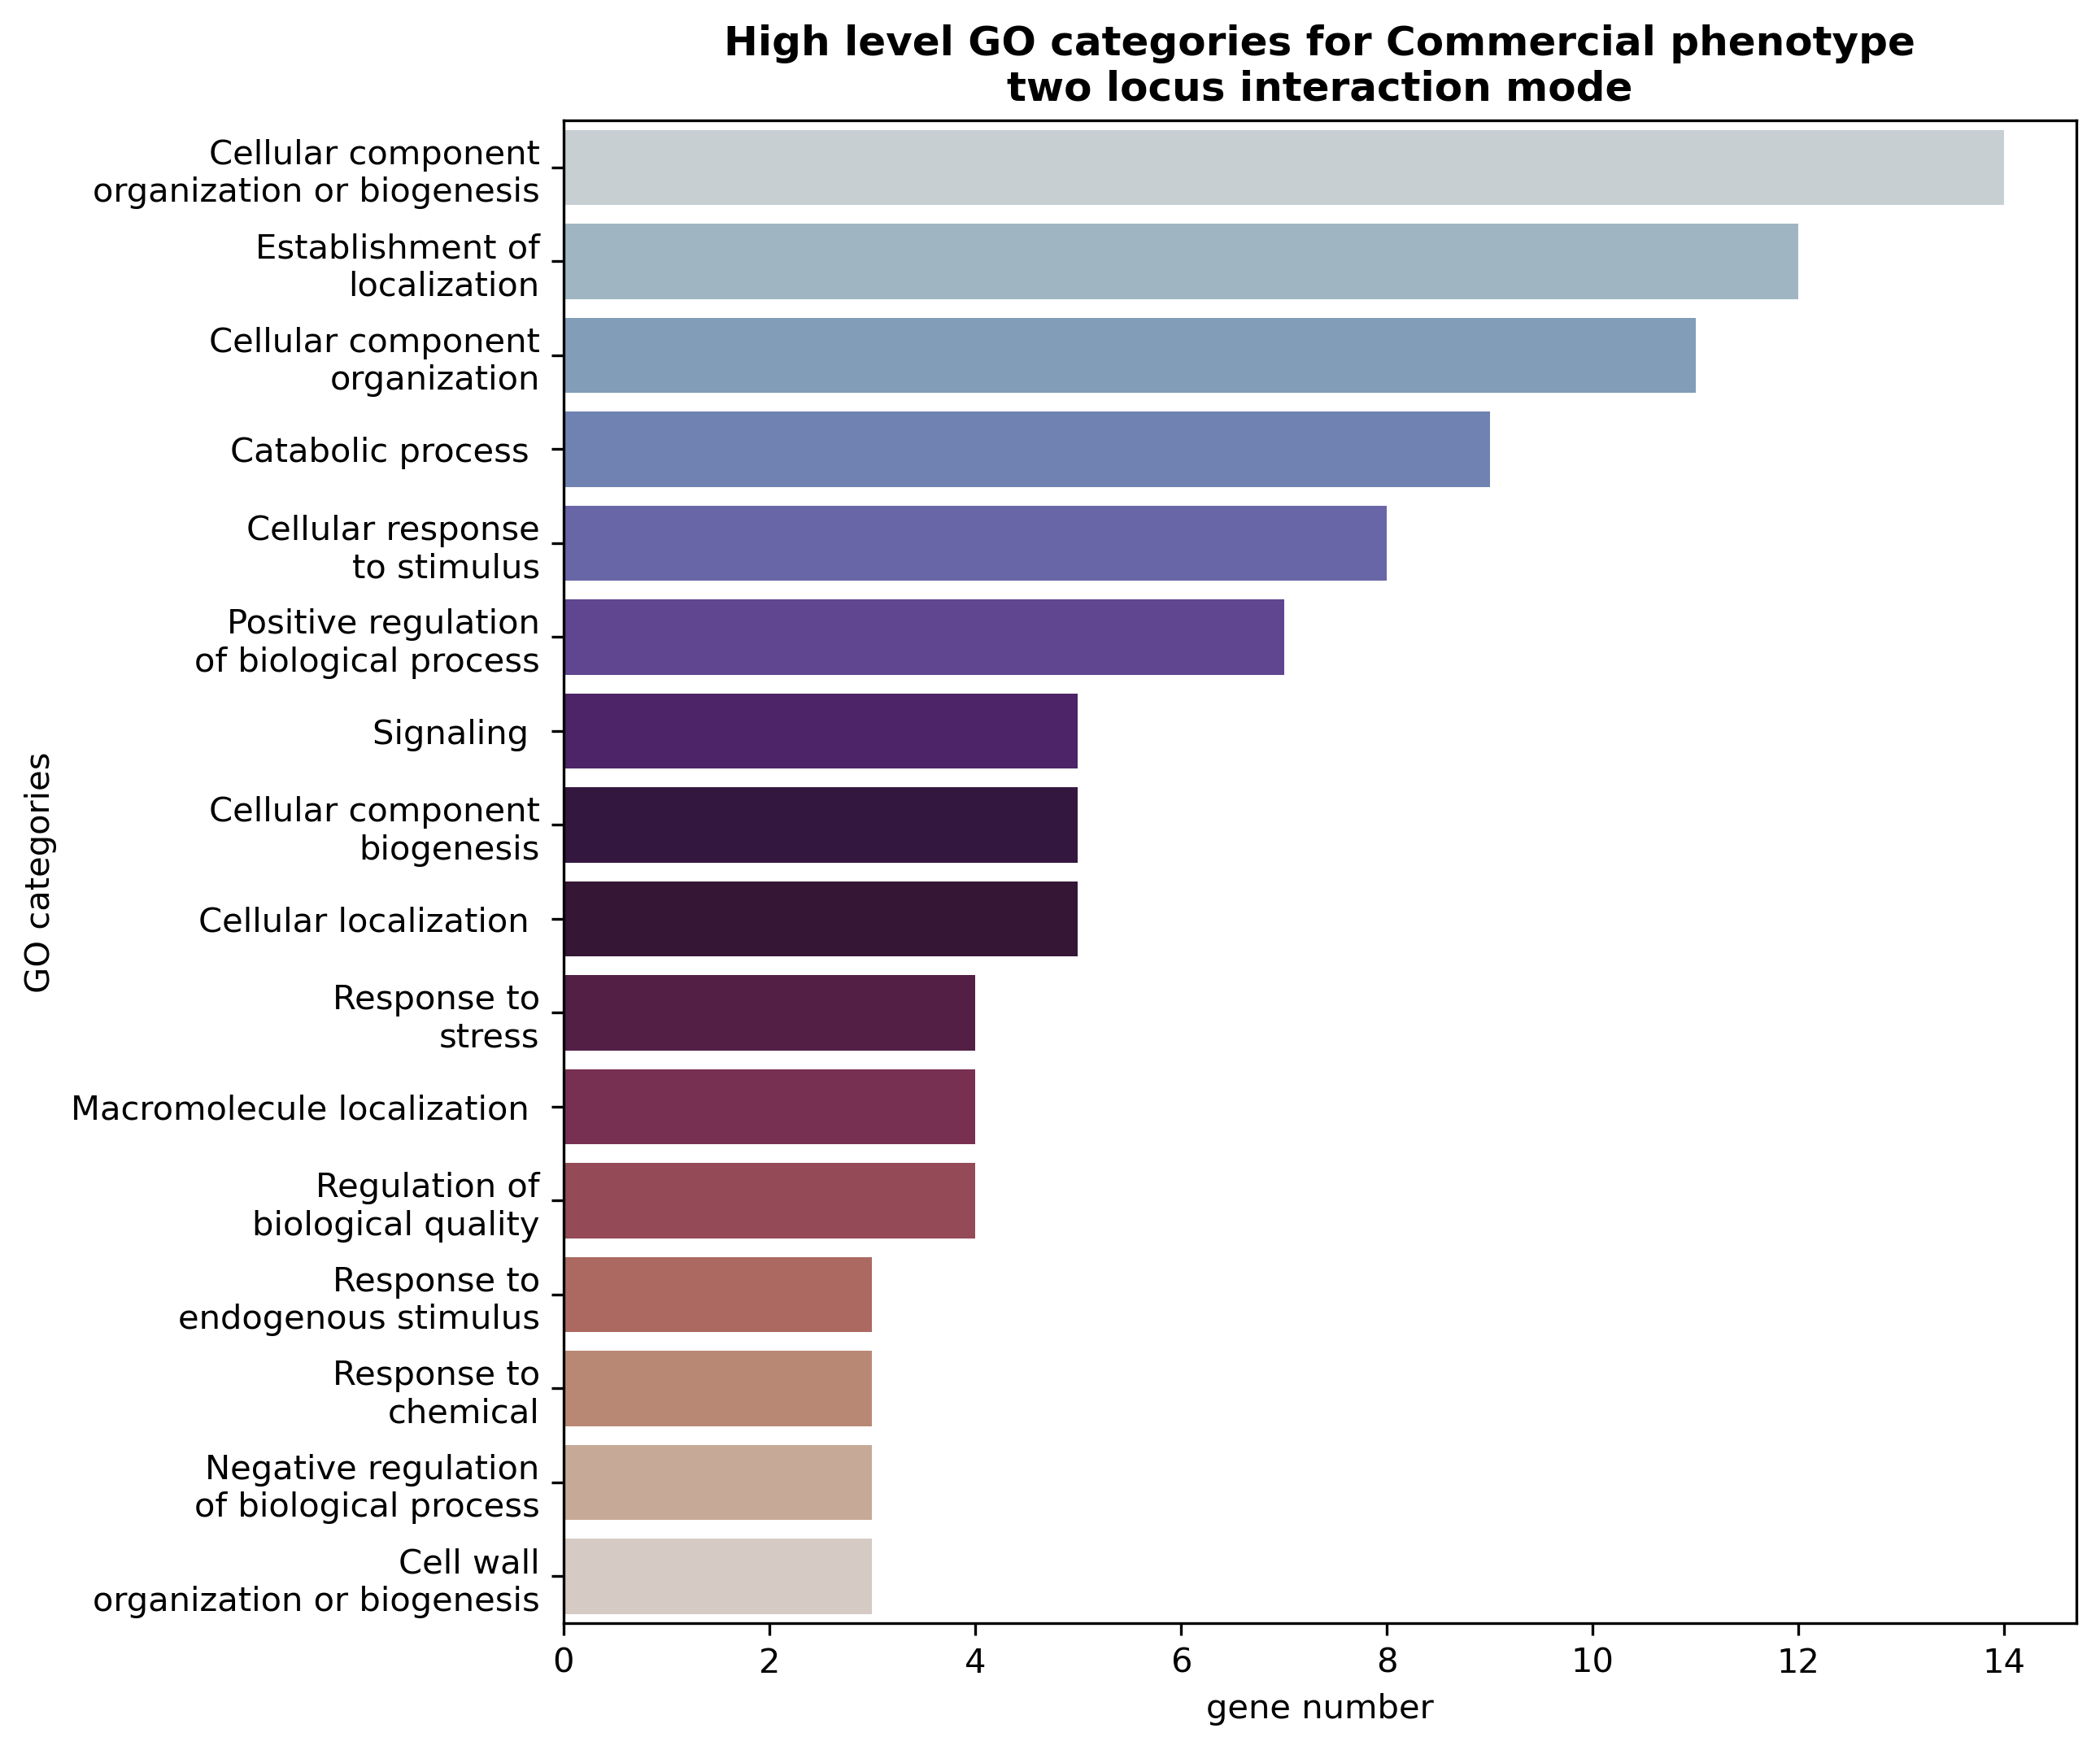

In [34]:
# barplot for High level GO category for two-loci interaction mode
fig, ax = plt.subplots(figsize=(8,8), dpi=300)
sns.barplot(data=GO_groups[GO_groups["N"] >= 3], x="N", y="High level GO category", ax=ax, palette="twilight")
plt.xlabel("gene number")
plt.ylabel("GO categories")
plt.savefig("../Pictures/hl_GO_secret_two.png", format="png", bbox_inches = 'tight')
ax.set_title("High level GO categories for Commercial phenotype\ntwo locus interaction mode", fontsize=12, fontweight="bold");

### Three loci interaction mode

The same analysis were performed for `AntEpiSeeker` *three-loci interaction* mode.

**NOTE**: For description of parameters see [README.md](../README.md) section **AntEpiSeeker parameters**.

- **parameters.txt** for THREE LOCUS interaction Commercial phenotype

| Parameter | Value | Description |
|-----------|:-----:|-------------|
| iAntCount | 1000  | number of ants |
| iItCountLarge | 14616 | number of iterations for the large haplotypes |
| iItCountSmall | 29231  | number of iterations for the small haplotypes |
| alpha     | 1 | weight given to pheromone deposited by ants |
| iTopModel | 1000 | number of top ranking haplotypes in the first stage |
| iTopLoci  | 200 | number of loci with top ranking pheromone in the first stage |
| rou | 0.05 | evaporation rate in Ant Colony Optimizaion |
| phe | 100 | initial pheromone level for each locus |
| largehapsize | 6 | size of the large haplotypes | 
| smallhapsize | 4 | size of the small haplotypes |
| iEpiModel | 3 | number of SNPs in an epistatic interaction |
| pvalue | 0.01 | p value threshold (after Bonferroni correction) |
| INPFILE | ../secret_med_input/secret012_discr_med.csv | input file name for case-control genotype data |
| OUTFILE | ../secret_three_loci/ant_result_secret_med_three_loci.txt | output file name for detected epistatic interactions |

In [35]:
# reading file with results for commercial dataset and three-loci interaction mode
secret_three_loci = pd.read_csv("../secret_three_loci/ant_result_secret_med_three_loci.txt",
                                sep='\t', skiprows=2, names=["Loci", "Chi-square", "p-value"])

# sorting dataframe by "Chi-square"
secret_three_loci.sort_values("Chi-square", ascending=False, ignore_index=True, inplace=True)

# splitting SNP pairs into three columns for convenience
secret_three_loci[["SNP1", "SNP2", "SNP3"]] = secret_three_loci.Loci.str.split(expand = True)
secret_three_loci.head()

,Loci,Chi-square,p-value,SNP1,SNP2,SNP3
0,13180(chr10:7811292) 2726(chr3:4289485) 25808(...,63.0216,0.000065,13180(chr10:7811292),2726(chr3:4289485),25808(chr18:57108550)
1,11269(chr8:47799279) 4601(chr4:11806702) 467(c...,59.0198,0.000227,11269(chr8:47799279),4601(chr4:11806702),467(chr1:29534257)
2,21908(chr16:25321851) 3016(chr3:10832879) 1328...,58.9737,0.000230,21908(chr16:25321851),3016(chr3:10832879),13284(chr10:10812414)
3,4603(chr4:11806835) 26427(chr19:18341163) 1988...,56.9068,0.000431,4603(chr4:11806835),26427(chr19:18341163),19880(chr15:22263798)
4,18539(chr14:35467294) 197(chr1:6439376) 14056(...,56.8028,0.000444,18539(chr14:35467294),197(chr1:6439376),14056(chr10:32824469)


As the result, we obtained **32** interacting SNP triplets.

#### Annotation

#### Preparation of .bed file for intersection with genome annotation

Then we prepared dataframe with SNP coordinates with chromosome names as in genome annotation file.

In [36]:
# generating dataframe with coordinates for each SNP in triplets
secret_three_loci = parse_snp_coord(dataframe=secret_three_loci, n_snps=3)
secret_three_loci.head()

,Loci,Chi-square,p-value,SNP1,SNP2,SNP3,SNP1_chr,SNP1_pos,SNP2_chr,SNP2_pos,SNP3_chr,SNP3_pos
0,13180(chr10:7811292) 2726(chr3:4289485) 25808(...,63.0216,0.000065,chr10:7811292,chr3:4289485,chr18:57108550,10,7811292,3,4289485,18,57108550
1,11269(chr8:47799279) 4601(chr4:11806702) 467(c...,59.0198,0.000227,chr8:47799279,chr4:11806702,chr1:29534257,8,47799279,4,11806702,1,29534257
2,21908(chr16:25321851) 3016(chr3:10832879) 1328...,58.9737,0.000230,chr16:25321851,chr3:10832879,chr10:10812414,16,25321851,3,10832879,10,10812414
3,4603(chr4:11806835) 26427(chr19:18341163) 1988...,56.9068,0.000431,chr4:11806835,chr19:18341163,chr15:22263798,4,11806835,19,18341163,15,22263798
4,18539(chr14:35467294) 197(chr1:6439376) 14056(...,56.8028,0.000444,chr14:35467294,chr1:6439376,chr10:32824469,14,35467294,1,6439376,10,32824469


In [37]:
# we decided to write SNP triplets (with IDs for each SNPs) in file to keep it as the result of AntEpiSeeker in more readable format
secret_three_loci.to_csv("../secret_three_loci/secret_three_loci_SNP_triplets.csv", 
                         columns=["SNP1", "SNP2", "SNP3"], index=False)

For further SNP annotation, we combined SNPs, found unique ones among them (in this case, it does not matter to us whether the SNP has met more than once in triplets), so for mapping SNPs on genes and analyze gene-gene interaction.

Then we prepared `.bed` file for intersection with [annotation](https://plants.ensembl.org/Glycine_max/Info/Index) `.gff3` file.

In [38]:
# path for .bed file
bed_path = "../secret_three_loci/secret_three_loci_coords/secret_ant_unique_coords_three_loci"

# generating .bed file for SNP annotation
unique_snps_df = generate_bed_file_unique(dataframe=secret_three_loci, bed_path=bed_path)

In [39]:
# this dataframe was written in .bed file
unique_snps_df.head()

,SNP_ID,chr,pos_stop,pos_start
0,chr10:7811292,10,7811292,7811291
1,chr8:47799279,8,47799279,47799278
2,chr16:25321851,16,25321851,25321850
3,chr4:11806835,4,11806835,11806834
4,chr14:35467294,14,35467294,35467293


#### Running bedtools intersect

To intersect SNPs with [genome annotation](https://plants.ensembl.org/Glycine_max/Info/Index) in `.gff3` format, we run `bedtools intersect` as follows:

```
bedtools intersect -wao -a ../secret_three_loci/secret_three_loci_coords/secret_ant_unique_coords_three_loci.bed \
-b ../../annotations/Glycine_max.Glycine_max_v2.1.56.gff3.gz > ../secret_three_loci/secret_three_loci_coords/secret_unique_intersect_three_loci.txt
```

#### Parsing features and filtering genes

After intersection with annotation file, we parsed resulted features and filtered genes.

In [40]:
# reading intersection file
# we only interested in columns with "SNP_ID", "chr", "type", "start", "stop", "features", "intersection_length"
secret_inter_three = pd.read_csv("../secret_three_loci/secret_three_loci_coords/secret_unique_intersect_three_loci.txt",
                                 sep="\t", usecols=[3, 4, 6, 7, 8, 12], header=None,
                                 names=["SNP_ID", "chr", "type", "start", "stop", "features"])

# filtering features with type "gene"
secret_inter_three = secret_inter_three[secret_inter_three["type"] == "gene"].reset_index(drop=True)

In [41]:
secret_inter_three.head()

,SNP_ID,chr,type,start,stop,features
0,chr10:7811292,10,gene,7798996,7816511,ID=gene:GLYMA_10G075300;biotype=protein_coding...
1,chr4:11806835,4,gene,11800500,11808533,ID=gene:GLYMA_04G109500;biotype=protein_coding...
2,chr6:9128442,6,gene,9126878,9129754,ID=gene:GLYMA_06G112500;biotype=protein_coding...
3,chr4:1907462,4,gene,1905904,1911083,ID=gene:GLYMA_04G023800;biotype=protein_coding...
4,chr3:4026286,3,gene,4026212,4030630,ID=gene:GLYMA_03G034400;biotype=protein_coding...


The "features" column contains a lot of information. The most valuable for our analysis is "gene ID". We parsed "features" in the following way.

In [42]:
# parsing column "features" to obtain gene attibutes (especially gene IDs)
secret_features_three = parse_features(secret_inter_three["features"])

# combining genes with respective SNPs
secret_features_three = pd.concat([secret_inter_three["SNP_ID"], secret_features_three], axis=1)
secret_features_three.head()

,SNP_ID,ID,biotype,description,gene_id,logic_name
0,chr10:7811292,gene:GLYMA_10G075300,protein_coding,hypothetical protein,GLYMA_10G075300,ena
1,chr4:11806835,gene:GLYMA_04G109500,protein_coding,hypothetical protein,GLYMA_04G109500,ena
2,chr6:9128442,gene:GLYMA_06G112500,protein_coding,hypothetical protein,GLYMA_06G112500,ena
3,chr4:1907462,gene:GLYMA_04G023800,protein_coding,hypothetical protein,GLYMA_04G023800,ena
4,chr3:4026286,gene:GLYMA_03G034400,protein_coding,hypothetical protein,GLYMA_03G034400,ena


It is known that the genome annotation may contain more than one entry about a genomic region (for example, some genes may overlap, or a gene may be annotated by different algorithms). Therefore, we checked whether there are duplicates in our case.

In [43]:
# checking duplicated SNP_IDs
secret_features_three[secret_features_three.duplicated(subset="SNP_ID", keep=False)]

,SNP_ID,ID,biotype,description,gene_id,logic_name
25,chr19:13707707,gene:GLYMA_19G063300,protein_coding,hypothetical protein,GLYMA_19G063300,ena
26,chr19:13707707,gene:GLYMA_19G063400,protein_coding,hypothetical protein,GLYMA_19G063400,ena


Yes, *one SNP ID* was duplicated. All genes are protein coding and hypothetical. We searched any information in [NCBI](https://www.ncbi.nlm.nih.gov/gene/) and [SoyBase](https://www.soybase.org/) databases about these genes. We did not found any descriptions about the possible functions of *GLYMA_19G063300* (index 25) and decided to remove it from further analysis. 

In [44]:
# removing genes GLYMA_19G063300 from further analysis
secret_features_three.drop(index=[25], inplace=True)

In [45]:
# saving gene features to file for any future purpose
secret_features_three.to_csv("../secret_three_loci/ant_secret_three_loci_unique_features.csv", index=False)

We have **42 genes** after SNP annotation, gene filtering, and dropping duplicated ones. We saved gene names to file for further enrichment analysis.

In [46]:
# saving gene names (lots of them starts with GLYMA) to file
# for further enrichment analysis
secret_features_three["gene_id"].to_csv("../secret_three_loci/secret_GLYMA_three.txt", sep="\n",
                                         header=None, index=False)

#### GO and KEGG enrichment analysis

Next, we generated DataFrame with gene pairs based on SNP annotation (for each SNP in triplets we replaced SNP ID with respective genes). As expected, we obtained 42 SNP-gene pairs.

In [47]:
# generating dictionary with SNP-gene pairs
snp_genes_dict_three = dict(zip(secret_features_three["SNP_ID"], secret_features_three["gene_id"]))
print(f"Number of SNP-gene triplets: {len(snp_genes_dict_three)}")

Number of SNP-gene triplets: 42


In [48]:
# copying initial DataFrame with SNP pairs
gene_triplets = secret_three_loci[["SNP1", "SNP2", "SNP3", "Chi-square"]].copy()

gene_triplets = assign_gene_for_snp(dataframe=gene_triplets, n_snps=3, snp_gene_dict=snp_genes_dict_three)

In [49]:
gene_triplets.head()

,SNP1,SNP2,SNP3,Chi-square,gene1,gene2,gene3
0,chr10:7811292,chr3:4289485,chr18:57108550,63.0216,GLYMA_10G075300,GLYMA_03G035500,GLYMA_18G292900
1,chr6:9128442,chr19:15262611,chr19:47351030,55.6492,GLYMA_06G112500,GLYMA_19G064200,GLYMA_19G221700


In [50]:
# saving SNP-SNP and respective gene triplets
gene_triplets.to_csv("../secret_three_loci/secret_three_loci_gene_triplets.csv", index=False)

After annotation, only **two gene triplets** with any information in `.gff3` file were remained.

Further, to perform GO and KEGG enrichment analysis, we converted gene names starts with "GLYMA" to respective Gene IDs using biological DataBase network and its utility for database to database conversions ([db2db](https://biodbnet.abcc.ncifcrf.gov/db/db2db.php)). Some IDs have been supplemented using [NCBI](https://www.ncbi.nlm.nih.gov/gene/) and [SoyBase](https://www.soybase.org/).

In [51]:
# reading file with gene info
secret_three_ids = pd.read_csv("../secret_three_loci/secret_three_loci_GLYMA_to_ID.txt", sep="\t", usecols=[0,1])

# parsing gene info to obtain Gene IDs for genes starts with "GLYMA"
secret_three_ids = parse_gene_info(secret_three_ids)

In [52]:
secret_three_ids.head()

,Gene Symbol and Synonyms,Gene Info,gene_ids
0,GLYMA_10G075300,100807843 [Gene Symbol: LOC100807843] [Locus T...,100807843
2,GLYMA_06G112500,100777292 [Gene Symbol: LOC100777292] [Locus T...,100777292
3,GLYMA_04G023800,100780634 [Gene Symbol: LOC100780634] [Locus T...,100780634
5,GLYMA_19G220100,100780968 [Gene Symbol: LOC100780968] [Locus T...,100780968
6,GLYMA_18G241400,100786634 [Gene Symbol: LOC100786634] [Locus T...,100786634


We wrote found *Gene IDs* to file for enrichment analysis.

In [53]:
# writing Gene IDs to file
secret_three_ids["gene_ids"].to_csv("../secret_three_loci/secret_ant_three_loci_gene_IDs.txt", sep="\n",
                              header=None, index=False)

Further, we used [ShinyGO 0.77](http://bioinformatics.sdstate.edu/go/) web tool to perform GO and KEGG annotation for each SNP in pairs. As the result, we found genes involved in *Positive regulation of biological process*, *Cellular response to stimulus*, *Signaling*, *Response to stress*, *etc*.

Finally, we visualized the High level GO categories obtained using [ShinyGO 0.77](http://bioinformatics.sdstate.edu/go/).

In [54]:
# reading file with High level GO categories (output of ShinyGo v0.77)
GO_groups_three = pd.read_csv("../secret_three_loci/secret_ant_three_loci_GO_groups.csv")

# inserting "\n" into string for visualization
GO_groups_three.loc[:, "High level GO category"] = GO_groups_three["High level GO category"].apply(parse_string)
GO_groups_three.head()

,N,High level GO category,Genes
0,4,Positive regulation\nof biological process,100788208 100780634 100791661 100793092
1,4,Cellular response\nto stimulus,100791661 100807843 547614 100807673
2,3,Signaling,100791661 100807843 547614
3,2,Response to\nstress,100791661 100807673
4,2,Negative regulation\nof biological process,100788208 100791661


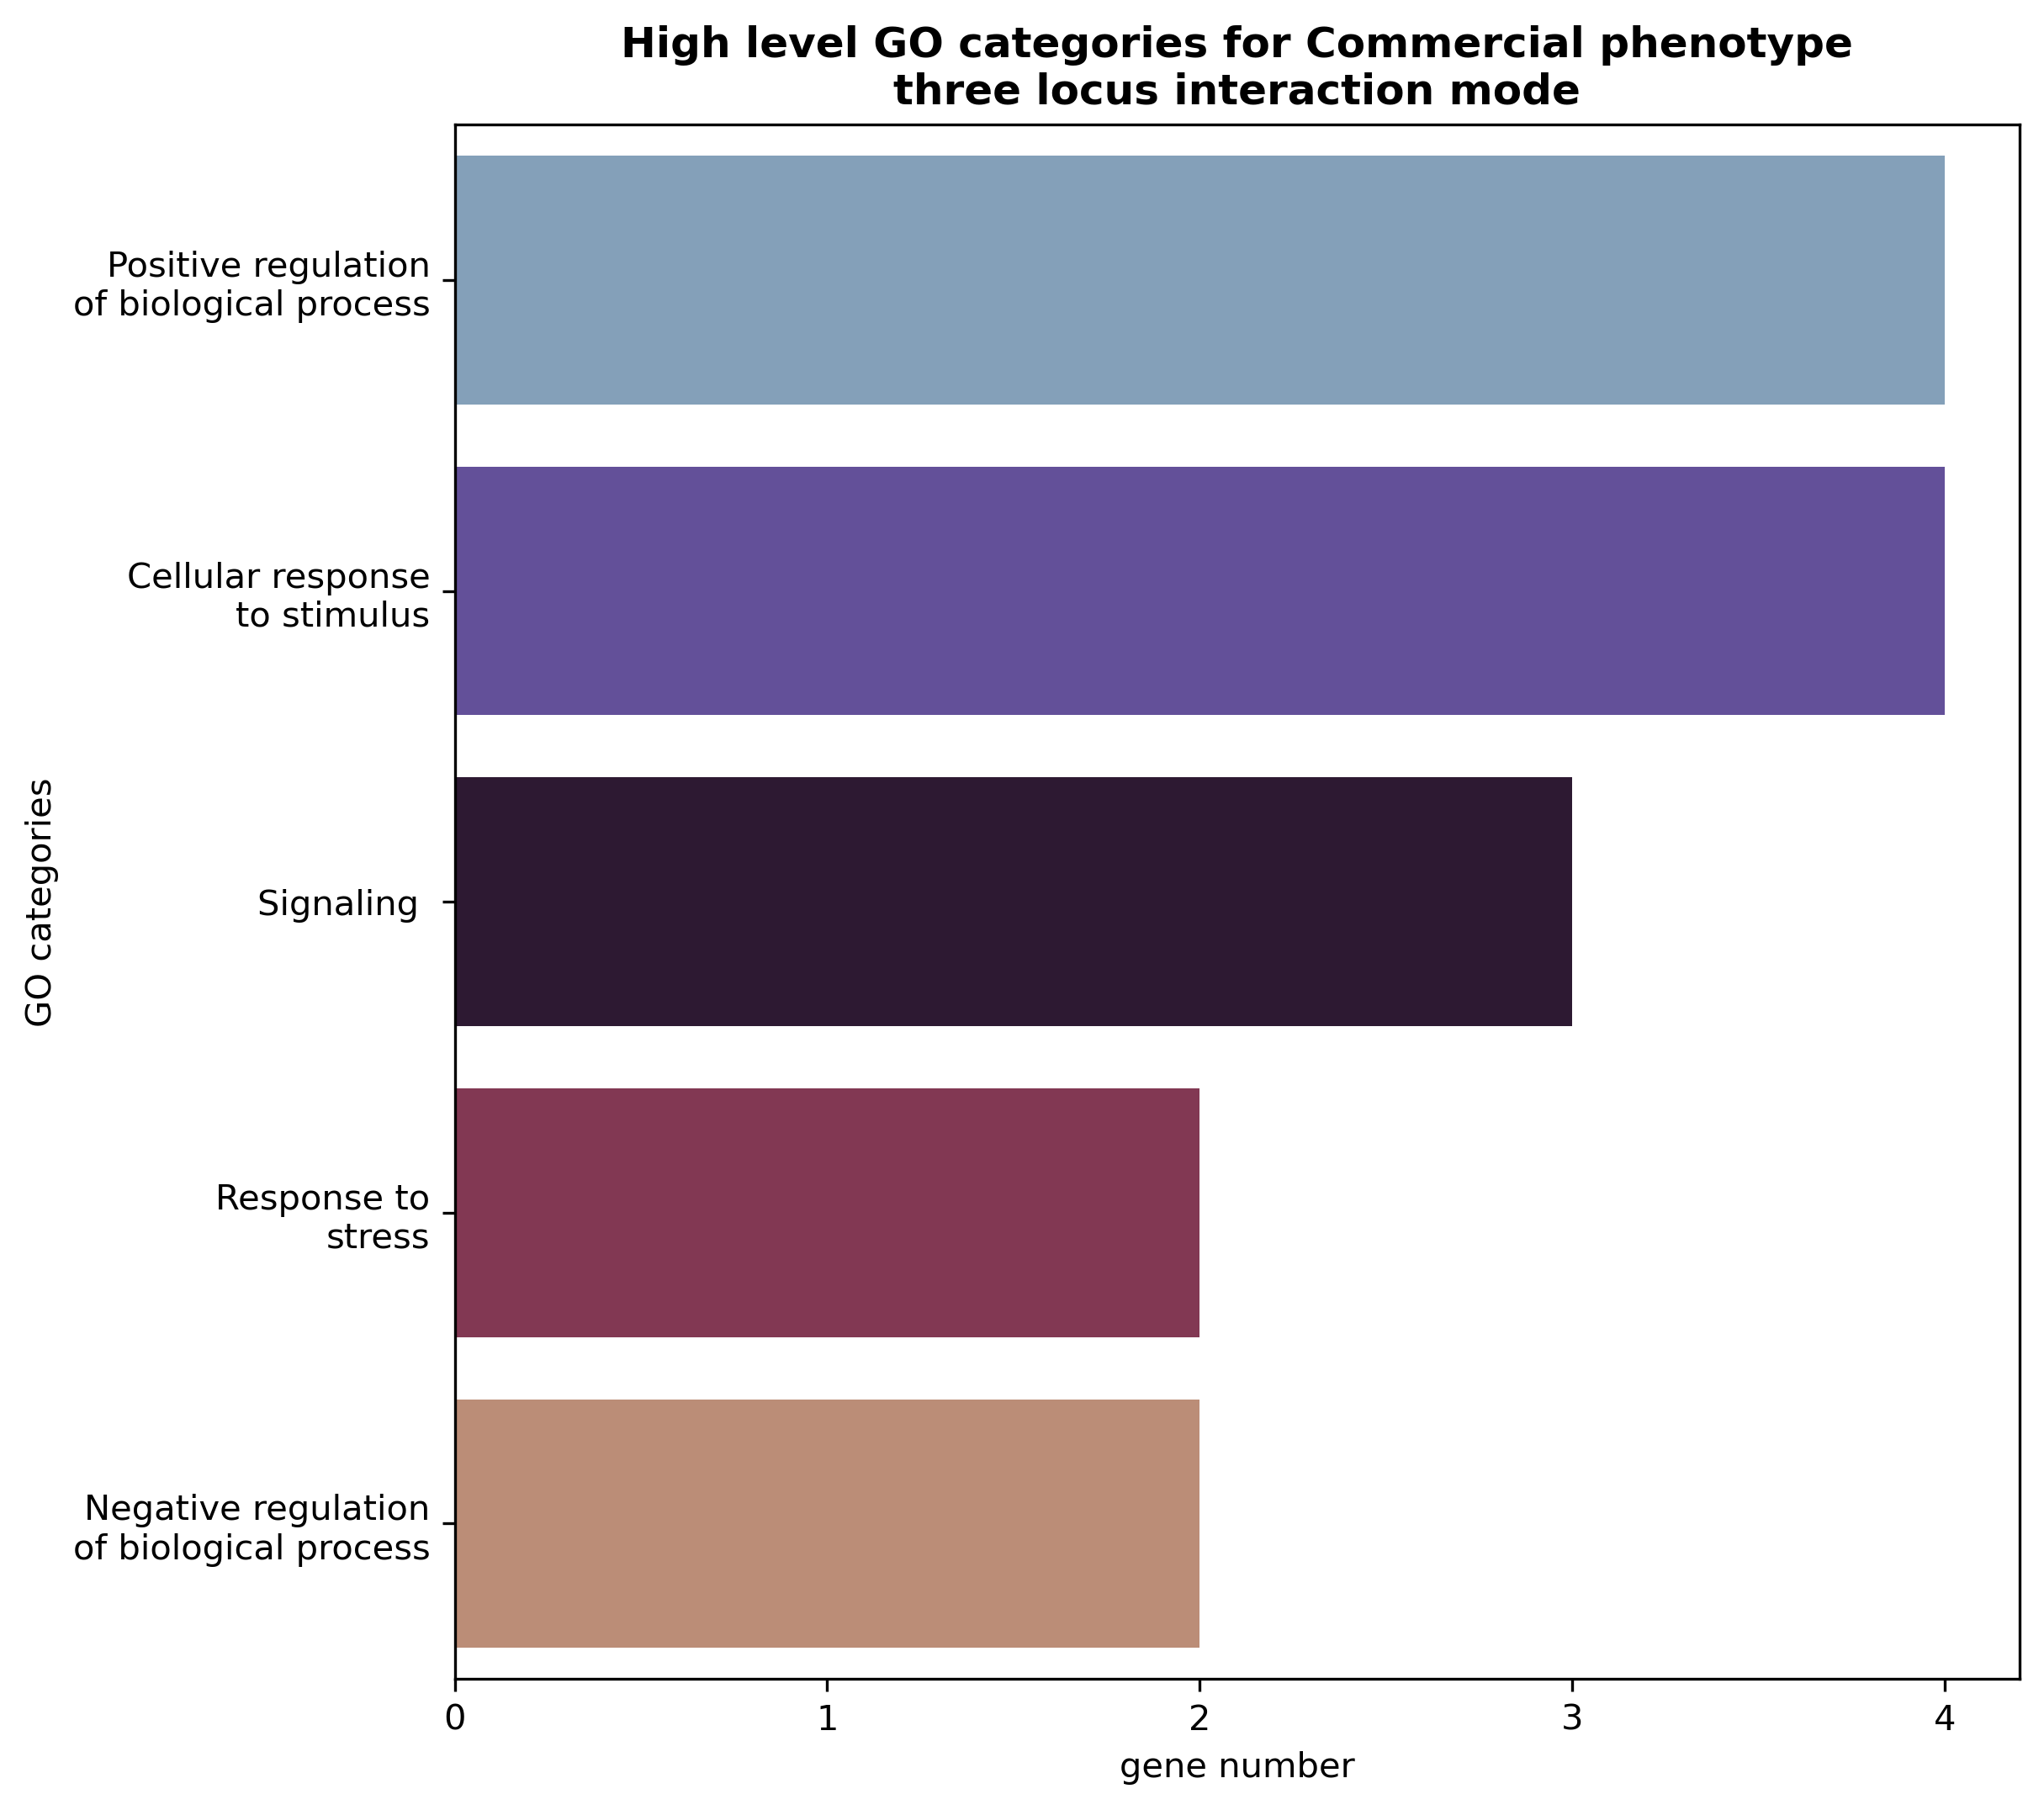

In [56]:
# barplot for High level GO category for three-loci interaction mode
from matplotlib.ticker import MaxNLocator


fig, ax = plt.subplots(figsize=(8,8), dpi=300)
sns.barplot(data=GO_groups_three[GO_groups_three["N"] >= 2], x="N", y="High level GO category", ax=ax, palette="twilight")
plt.xlabel("gene number")
plt.ylabel("GO categories")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig("../Pictures/hl_GO_secret_three.png", format="png", bbox_inches = 'tight')
ax.set_title("High level GO categories for Commercial phenotype\nthree locus interaction mode", fontsize=12, fontweight="bold");